In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sTools
import Tools
from grizli.aws import db
from grizli import utils
from astropy.io import fits

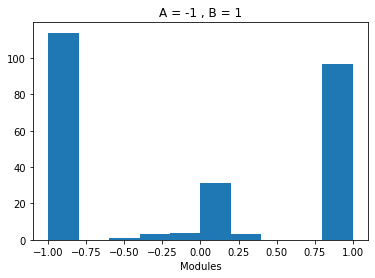

In [2]:
%load_ext autoreload
%autoreload

#Load data of exposures from SQL query done by Gabe
Run=True
if Run ==True:
    showPlot=False
    Verbose=True
    ##### Find exposures that overlap a point
    #point = [189.2, 62.27]
    points=np.load("../Catalogs/WaveOff_Merged_Coord.npy")


    modNums=[]

    for point in points:
        temp=sTools.ExposureModules(point,showPlot=showPlot)
        #print(temp)
        modNums.append(temp[1])

    np.save("../Catalogs/ExpositionsGrizli_modNums.npy",modNums)
    plt.hist(modNums)
    plt.xlabel("Modules")
    plt.title("A = -1 , B = 1")
    plt.show()

11 exposures cover the point [189.2, 62.27]


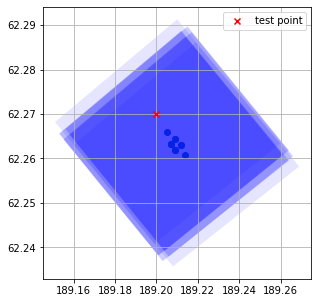

In [5]:
exp=fits.open("../data/large_files/FrescoDatabase/fresco_exposure_footprints.fits")[1].data

coord=[189.2, 62.27]

has_point = np.array([utils.SRegion(fp).path[0].contains_point(coord)
                    for fp in exp['footprint']])

modules=[sTools.FindModule(e) for e in exp[has_point]]


print(f'{has_point.sum()} exposures cover the point {coord}')


fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(exp['crval1'][has_point], exp['crval2'][has_point])
for fp in exp['footprint'][has_point]:
    sr = utils.SRegion(fp)
    
    for p in sr.patch(fc='b', ec='None', alpha=0.1):
        ax.add_patch(p)
        
ax.scatter(*coord, marker='x', color='r', zorder=100, label='test point')
ax.legend()

ax.grid()
ax.set_aspect(1./np.cos(coord[1]/180*np.pi))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


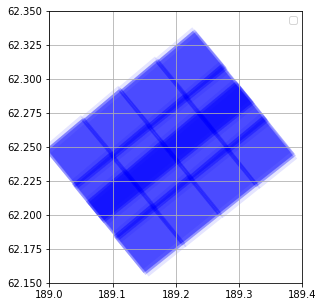

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


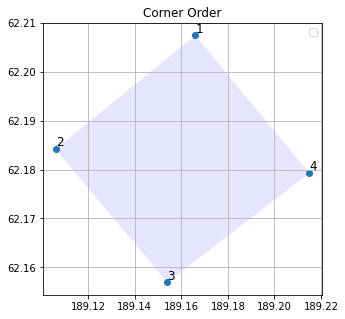

In [6]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
for fp in exp['footprint']:
            sr = utils.SRegion(fp)
            
            for p in sr.patch(fc='b', ec='None', alpha=0.1):
                ax.add_patch(p)
                

ax.set_xlim(189.,189.4)
ax.set_ylim(62.15,62.35)
ax.legend()
ax.grid()
ax.set_aspect(1./np.cos(coord[1]/180*np.pi))
plt.show()

#######
#######

fig, ax = plt.subplots(1,1,figsize=(5,5))
fp=exp['footprint'][178]
sr = utils.SRegion(fp)
for p in sr.patch(fc='b', ec='None', alpha=0.1):
    ax.add_patch(p)
        
#ax.scatter(*coord, marker='x', color='r', zorder=100, label='test point')

ax.legend()
ax.grid()
ax.autoscale_view()
plt.title("Corner Order")
#ax.set_aspect(1./np.cos(coord[1]/180*np.pi))
Corners=np.array(Tools.convert_string_to_2d_array(fp))
Tools.plot_points_with_numbers(np.transpose(Corners))
plt.show()

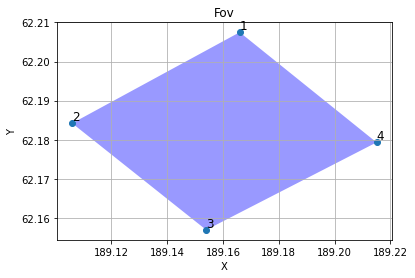

In [7]:
from matplotlib.patches import Polygon

Corners=np.array(Tools.convert_string_to_2d_array(fp))
square = Polygon(list(zip(*Corners)), closed=True, facecolor='blue', alpha=0.4)

fig, ax = plt.subplots()
ax.add_patch(square)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Fov')

ax.autoscale_view()
Tools.plot_points_with_numbers(np.transpose(Corners))
#ax.set_aspect(1./np.cos(coord[1]/180*np.pi))
plt.grid(True)
plt.show()


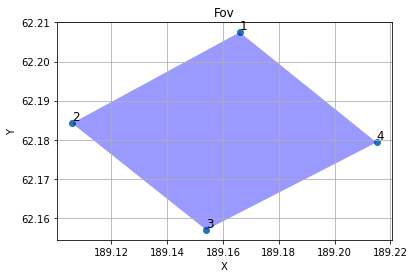

In [8]:


#smallerShape=[[189.18,62.26],[189.2,62.27],[189.22,62.27],[189.22,62.25]]

OrderedCorners=np.transpose(Corners)
square = Polygon(list(zip(*np.transpose(OrderedCorners))), closed=True, facecolor='blue', alpha=0.4)
#square2 = Polygon(list(zip(*np.transpose(smallerShape))), closed=True, facecolor='blue', alpha=0.4)

fig, ax = plt.subplots()
Tools.plot_points_with_numbers(OrderedCorners)
ax.add_patch(square)
#ax.add_patch(square2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Fov')
ax.autoscale_view()
plt.grid(True)
plt.show()

In [9]:
from skimage.transform import ProjectiveTransform

t = ProjectiveTransform()
src = np.asarray(OrderedCorners)
dst = np.asarray([[0, 0], [0, 2040], [2040, 2040], [2040, 0]])
if not t.estimate(src, dst): raise Exception("estimate failed")

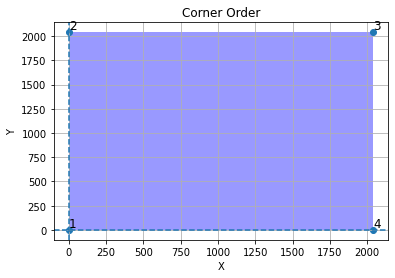

In [10]:
SquaredCorner=t(OrderedCorners)
#SquaredShape=t(smallerShape)


square = Polygon(list(zip(*np.transpose(SquaredCorner))), closed=True, facecolor='blue', alpha=0.4)
#square2 = Polygon(list(zip(*np.transpose(SquaredShape))), closed=True, facecolor='blue', alpha=0.4)
fig, ax = plt.subplots()
ax.add_patch(square)
#ax.add_patch(square2)
#Inverted order of points to clockwise
Tools.plot_points_with_numbers(SquaredCorner)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Fov')
ax.axvline(x=0,ls="--")
ax.axhline(y=0,ls="--")
ax.autoscale_view()
plt.title("Corner Order")
plt.grid(True)
plt.show()

In [11]:
gals=np.load("../Catalogs/WaveOff_Merged_Coord.npy")
voff=np.load("../Catalogs/WaveOff_Merged_Voff.npy")
exp=fits.open("../data/large_files/FrescoDatabase/fresco_exposure_footprints.fits")[1].data

def all_equal(iterator):
    iterator = iter(iterator)
    try:
        first = next(iterator)
    except StopIteration:
        return True
    return all(first == x for x in iterator)

def check_majority(array):
    element_count = {}
    for element in array:
        if element in element_count:
            element_count[element] += 1
        else:
            element_count[element] = 1
    
    max_frequency = max(element_count.values())
    if max_frequency > len(array) * 0.9:
        return True
    else:
        return False

Result=[]
for coord,voff in zip(gals[:],voff[:]):
    print(coord)
    has_point = np.array([utils.SRegion(fp).path[0].contains_point(coord)
                        for fp in exp['footprint']])

    temp=[]
    pixs=[]
    for e in exp[has_point]:
        thisExp={"module":None,"pix":None,"offset":voff,"coord":coord}
        thisExp["module"]=sTools.FindModule(e) 

        #Get pixel coord
        Corners=np.array(Tools.convert_string_to_2d_array(e["footprint"]))
        OrderedCorners=np.transpose(Corners)
        t = ProjectiveTransform()
        src = np.asarray(OrderedCorners)
        dst = np.asarray([[0, 0], [0, 2040], [2040, 2040], [2040, 0]])
        if not t.estimate(src, dst): raise Exception("estimate failed")
        PixGal=t(coord)
        PixGal=np.round(PixGal).astype(int)

        thisExp["pix"]=PixGal
        pixs.append(PixGal)
        temp.append(thisExp)

    modules=[t["module"] for t in temp]

    #print(pixs)
    #print(np.std(np.transpose(pixs)[0][0]),np.std(np.transpose(pixs)[1][0]))


    if check_majority(modules)==True and (  np.std(np.transpose(pixs)[0][0])<200 and np.std(np.transpose(pixs)[1][0])<200):
        #Result.append(temp)
        Result.append({"module":modules[0],"pix":np.round(np.mean(pixs,axis=0)).astype(int),"offset":voff,"coord":coord})



#temp=[]
#for r in Result:
#    for rr in r:
#        temp.append(rr)
#Result=temp

[ 53.15735937 -27.87014467]
[ 53.07664464 -27.83035295]
[ 53.06191281 -27.82024311]
[ 53.07691177 -27.79926371]
[ 53.10087288 -27.78336245]
[ 53.07892717 -27.79971347]
[ 53.0765547  -27.83116317]
[ 53.14709839 -27.7784967 ]
[ 53.14665823 -27.77757128]
[ 53.07064308 -27.83443137]
[ 53.14778785 -27.77701203]
[ 53.09511659 -27.75519431]
[ 53.14791423 -27.77430289]
[ 53.1159846  -27.83118734]
[ 53.10011795 -27.73571027]
[ 53.151028   -27.80949912]
[ 53.07311519 -27.77053363]
[ 53.14786419 -27.77410436]
[ 53.16046101 -27.79044947]
[ 53.17897132 -27.79874635]
[ 53.09706787 -27.79523578]
[ 53.07387158 -27.78424291]
[ 53.14910918 -27.77437002]
[ 53.15664931 -27.79438659]
[ 53.18177452 -27.78303861]
[ 53.1946199  -27.76563681]
[ 53.18419413 -27.79164296]
[ 53.16619837 -27.78759446]
[ 53.18336411 -27.77619937]
[ 53.17754185 -27.76860937]
[ 53.14453035 -27.77911893]
[ 53.10776693 -27.83890224]
[ 53.15830813 -27.77751633]
[ 53.16757575 -27.79257518]
[ 53.16362193 -27.75903471]
[ 53.16411573 -27.78

In [12]:
Module="B"

pixels=[]
voffs=[]
for ob in Result:
    if ob["module"]==Module:
        pixels.append(ob["pix"])
        voffs.append(ob["offset"])

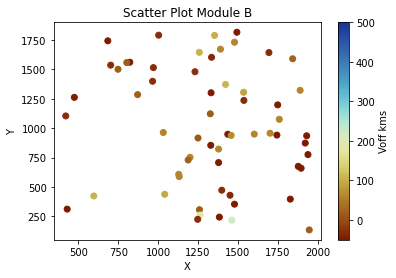

In [17]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

from palettable.scientific.diverging import Roma_16


cmap = Roma_16.mpl_colormap

new_cmap = truncate_colormap(cmap, 0., 1.)

scatter = plt.scatter(*np.transpose(pixels), c=voffs, cmap=new_cmap,vmin=-50, vmax=500)
# Add colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Voff kms')

# Set labels and title for the plot
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot Module '+Module)

# Show the plot
plt.show()

In [18]:
rows = 2040
columns = 2040

# Create an empty 2D array
array_2d = [[[] for _ in range(columns)] for _ in range(rows)]

for pix,v in zip(pixels,voffs):
    pix=pix[0]
    x,y=pix[0],pix[1]
    array_2d[x][y].append(v)
    




for x in range(0,2040):
    for y in range(0,2040):
        if len(array_2d[x][y])==0:
            array_2d[x][y]=np.nan
            continue
        array_2d[x][y]=np.nanmedian(array_2d[x][y])



In [19]:
new=[]
for x in range(0,2040):
    for y in range(0,2040):
        if np.isnan(array_2d[x][y])==False:
            new.append({"pix":(x,y),"voff":array_2d[x][y]})

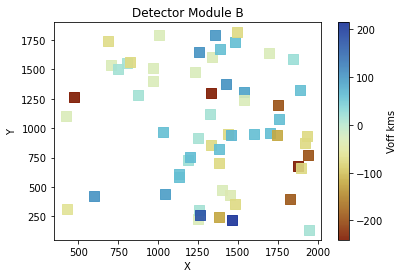

In [26]:
cord=[c["pix"] for c in new]
vof=[c["voff"] for c in new]


scatter = plt.scatter(*np.transpose(cord),marker="s",s=100,alpha=0.9, c=vof, cmap=new_cmap)
# Add colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Voff kms')

# Set labels and title for the plot
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Detector Module '+Module)

# Show the plot
plt.show()

In [21]:
def fit_and_plot_line(X, Y):
    # Fit a line (linear regression)
    idx = np.isfinite(X) & np.isfinite(Y)
    X=np.array(X)[idx]
    Y=np.array(Y)[idx]
    coefficients = np.polyfit(X, Y, 1)

    m = coefficients[0]  # Slope
    b = coefficients[1]  # Intercept

    # Generate line values
    line_x = np.linspace(X.min(), X.max(), 100)
    line_y = m * line_x + b

    # Plot the original data and the fitted line

    plt.plot(line_x, line_y, color='red', label='Fit : offset = '+ str(np.round(m,4)) +" * X +" + str(np.round(b,2)))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Fitted Line Plot')




/Users/gonzalo/opt/anaconda3/envs/grizli39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


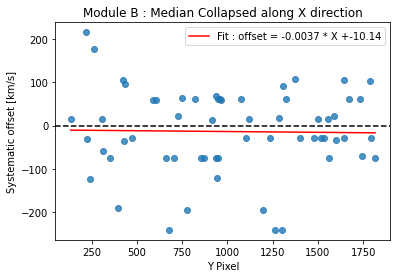

-0.0188753644990326 0.8861756558579098


In [22]:
from scipy.stats import pearsonr
# collapse X axis
collapsed=[]
for y in range(0,2040):
    temp=[]
    for x in range(0,2040):
        temp.append(array_2d[x][y])
    collapsed.append(np.nanmedian(temp))

#mask=np.array(collapsed)<400
#collapsed=np.array(collapsed)[mask]

x=np.linspace(0,2039,2040)
#x=x[mask]
plt.axhline(y=0,ls="--",color="black")



plt.scatter(x,collapsed,alpha=0.8)
fit_and_plot_line(x,collapsed)
plt.title("Module "+Module+" : Median Collapsed along X direction")
plt.xlabel("Y Pixel")
plt.ylabel("Systematic offset [km/s]")
plt.legend()
plt.show()



# Calculate p-value using Pearson correlation coefficient
idx = np.isfinite(x) & np.isfinite(collapsed)
X=np.array(x)[idx]
Y=np.array(collapsed)[idx]
correlation, p_value = pearsonr(X, Y)
print(correlation,p_value)

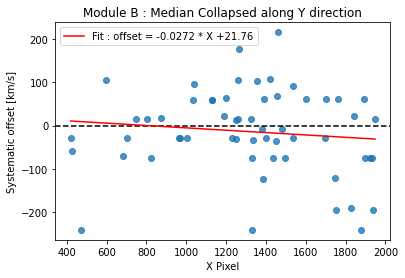

-0.11410242496793133 0.39374146139251665


In [23]:
# collapse X axis
collapsed=[]
for x in range(0,2040):
    temp=[]
    for y in range(0,2040):
        temp.append(array_2d[x][y])
    collapsed.append(np.nanmedian(temp))
#mask=np.array(collapsed)<400
#collapsed=np.array(collapsed)[mask]
x=np.linspace(0,2039,2040)
#x=x[mask]
plt.scatter(x,collapsed,alpha=0.8)
plt.axhline(y=0,ls="--",color="black")
fit_and_plot_line(x,collapsed)
plt.title("Module "+Module+" : Median Collapsed along Y direction")
plt.xlabel("X Pixel")
plt.ylabel("Systematic offset [km/s]")
plt.legend()
plt.show()

# Calculate p-value using Pearson correlation coefficient
idx = np.isfinite(x) & np.isfinite(collapsed)
X=np.array(x)[idx]
Y=np.array(collapsed)[idx]
correlation, p_value = pearsonr(X, Y)
print(correlation,p_value)